In [1]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [2]:
# Function to load and preprocess images
def load_images_from_directory(base_path, emotion_labels, img_size=(48, 48)):
    faces = []
    emotions = []
    for emotion, label in emotion_labels.items():
        emotion_folder = os.path.join(base_path, emotion)
        for filename in os.listdir(emotion_folder):
            if filename.endswith('.png') or filename.endswith('.jpg'):
                img_path = os.path.join(emotion_folder, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, img_size)
                faces.append(img.astype('float32'))
                emotions.append(label)
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    emotions = np.asarray(emotions)
    emotions = np.eye(len(emotion_labels))[emotions]  # One-hot encode
    return faces, emotions

In [3]:
# Define emotion labels
emotion_labels = {'angry': 0, 'disgust': 1, 'fear': 2, 'sad': 3, 'happy': 4, 'neutral': 5, 'surprise': 6}

In [5]:
# Load FER-2013 dataset
faces_fer, emotions_fer = load_images_from_directory(r"C:\Users\User\OneDrive\Desktop\EmoSense\Face Emotion Recognition\fer2013\train", emotion_labels)

# Load kaggle dataset
faces_ck, emotions_ck = load_images_from_directory(r"C:\Users\User\OneDrive\Desktop\EmoSense\Face Emotion Recognition\archive\images\images\train", emotion_labels)

In [6]:
# Normalize pixel values to the range [0, 1]
faces_fer /= 255.0
faces_ck /= 255.0

In [7]:
# Combine datasets
faces_combined = np.concatenate((faces_fer, faces_ck), axis=0)
emotions_combined = np.concatenate((emotions_fer, emotions_ck), axis=0)

# Shuffle the combined dataset
faces_combined, emotions_combined = shuffle(faces_combined, emotions_combined, random_state=42)

In [8]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(faces_combined, emotions_combined, test_size=0.2, random_state=42)

In [9]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

In [10]:
# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 classes for emotion detection
])

In [11]:
# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 10, 10, 64)        0

In [12]:
# Train the model
batch_size = 64
epochs = 100

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs
)

Epoch 1/100


719/719 [==============================] - 64s 87ms/step - loss: 1.8364 - accuracy: 0.2352 - val_loss: 1.8569 - val_accuracy: 0.2486
Epoch 2/100
719/719 [==============================] - 64s 89ms/step - loss: 1.7951 - accuracy: 0.2538 - val_loss: 1.7947 - val_accuracy: 0.2734
Epoch 3/100
719/719 [==============================] - 63s 87ms/step - loss: 1.7626 - accuracy: 0.2756 - val_loss: 1.7339 - val_accuracy: 0.3355
Epoch 4/100
719/719 [==============================] - 64s 90ms/step - loss: 1.7285 - accuracy: 0.3036 - val_loss: 1.6791 - val_accuracy: 0.3731
Epoch 5/100
719/719 [==============================] - 63s 87ms/step - loss: 1.6977 - accuracy: 0.3201 - val_loss: 1.6296 - val_accuracy: 0.3583
Epoch 6/100
719/719 [==============================] - 63s 88ms/step - loss: 1.6735 - accuracy: 0.3355 - val_loss: 1.5825 - val_accuracy: 0.3952
Epoch 7/100
719/719 [==============================] - 62s 87ms/step - loss: 1.6483 - accuracy: 0.3535 - val_loss: 1.5567 - val_

719/719 [==============================] - 62s 86ms/step - loss: 1.2368 - accuracy: 0.5307 - val_loss: 1.1059 - val_accuracy: 0.5772
Epoch 55/100
719/719 [==============================] - 62s 86ms/step - loss: 1.2296 - accuracy: 0.5339 - val_loss: 1.1009 - val_accuracy: 0.5792
Epoch 56/100
719/719 [==============================] - 61s 85ms/step - loss: 1.2324 - accuracy: 0.5339 - val_loss: 1.0956 - val_accuracy: 0.5844
Epoch 57/100
719/719 [==============================] - 61s 85ms/step - loss: 1.2231 - accuracy: 0.5351 - val_loss: 1.0971 - val_accuracy: 0.5822
Epoch 58/100
719/719 [==============================] - 61s 84ms/step - loss: 1.2209 - accuracy: 0.5386 - val_loss: 1.0974 - val_accuracy: 0.5840
Epoch 59/100
719/719 [==============================] - 61s 85ms/step - loss: 1.2237 - accuracy: 0.5369 - val_loss: 1.0899 - val_accuracy: 0.5827
Epoch 60/100
719/719 [==============================] - 61s 85ms/step - loss: 1.2169 - accuracy: 0.5387 - val_loss: 1.0965 - val_accuracy

In [13]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')


360/360 [==============================] - 4s 11ms/step - loss: 1.0144 - accuracy: 0.6199
Validation Loss: 1.0144048929214478
Validation Accuracy: 0.6199374198913574


In [14]:
# Save the model
model.save('emotion_recognition_model-1.keras')

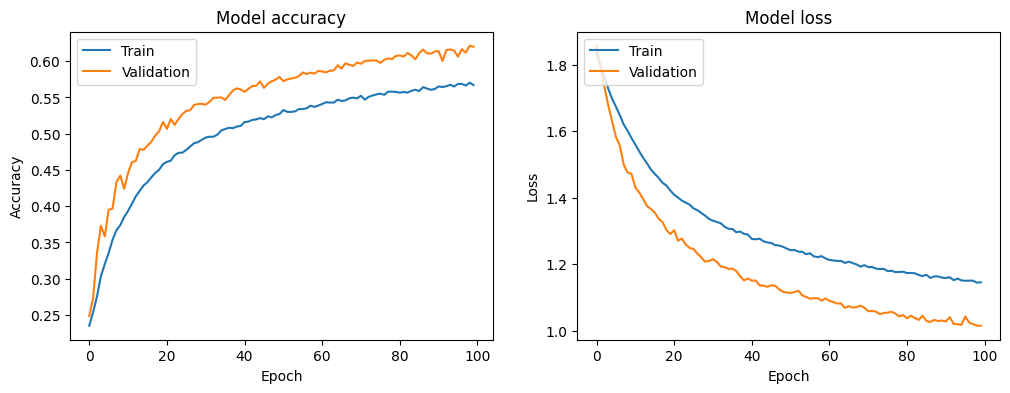

In [15]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

plot_history(history)


360/360 [==============================] - 3s 9ms/step


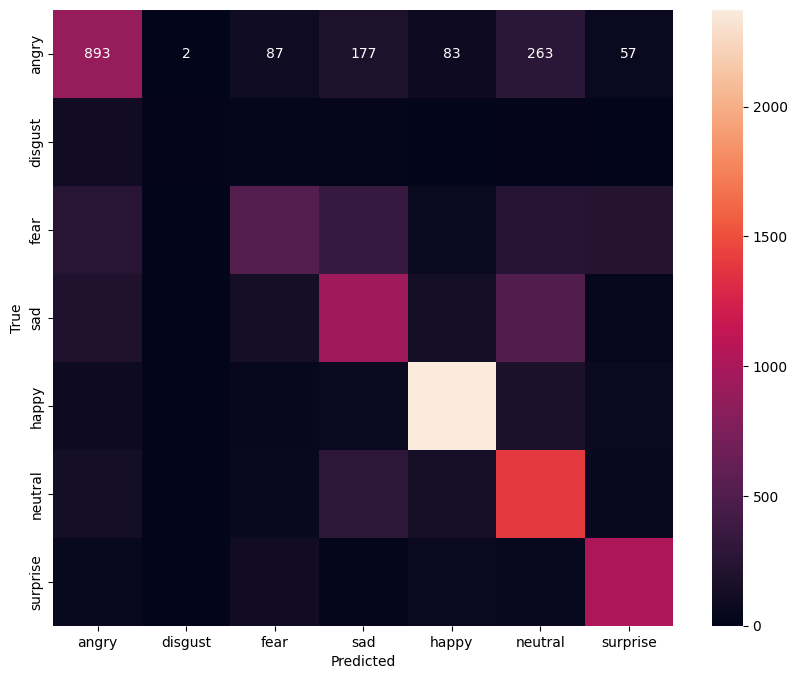

              precision    recall  f1-score   support

       angry       0.52      0.57      0.55      1562
     disgust       0.74      0.07      0.13       196
        fear       0.53      0.31      0.39      1642
         sad       0.50      0.48      0.49      1934
       happy       0.83      0.84      0.83      2816
     neutral       0.53      0.68      0.60      2050
    surprise       0.69      0.77      0.73      1306

    accuracy                           0.62     11506
   macro avg       0.62      0.53      0.53     11506
weighted avg       0.62      0.62      0.61     11506



In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
class_names = list(emotion_labels.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))


In [5]:
#Only FER2013 dataset -------Training 2--------- 

In [ ]:
# Epoch 50 Batch Size 64

In [6]:
# Define parameters
img_width, img_height = 48, 48
batch_size = 64
epochs = 50

In [7]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
# Load FER-2013 dataset
train_generator = train_datagen.flow_from_directory(
    r"C:\Users\User\OneDrive\Desktop\EmoSense\Face Emotion Recognition\fer2013\train",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    r"C:\Users\User\OneDrive\Desktop\EmoSense\Face Emotion Recognition\fer2013\test",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [9]:
# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 classes for the 7 emotions
])


In [10]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/50


448/448 [==============================] - 84s 185ms/step - loss: 1.7689 - accuracy: 0.2717 - val_loss: 1.6816 - val_accuracy: 0.3251
Epoch 2/50
448/448 [==============================] - 52s 115ms/step - loss: 1.6225 - accuracy: 0.3587 - val_loss: 1.4419 - val_accuracy: 0.4460
Epoch 3/50
448/448 [==============================] - 53s 119ms/step - loss: 1.4927 - accuracy: 0.4266 - val_loss: 1.3512 - val_accuracy: 0.4874
Epoch 4/50
448/448 [==============================] - 52s 115ms/step - loss: 1.4191 - accuracy: 0.4552 - val_loss: 1.3201 - val_accuracy: 0.4962
Epoch 5/50
448/448 [==============================] - 53s 119ms/step - loss: 1.3657 - accuracy: 0.4758 - val_loss: 1.2595 - val_accuracy: 0.5158
Epoch 6/50
448/448 [==============================] - 51s 114ms/step - loss: 1.3296 - accuracy: 0.4917 - val_loss: 1.2360 - val_accuracy: 0.5292
Epoch 7/50
448/448 [==============================] - 54s 121ms/step - loss: 1.3050 - accuracy: 0.5030 - val_loss: 1.2520 - val_

In [12]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

113/113 [==============================] - 4s 39ms/step - loss: 1.0539 - accuracy: 0.6045
Validation Accuracy: 60.45%


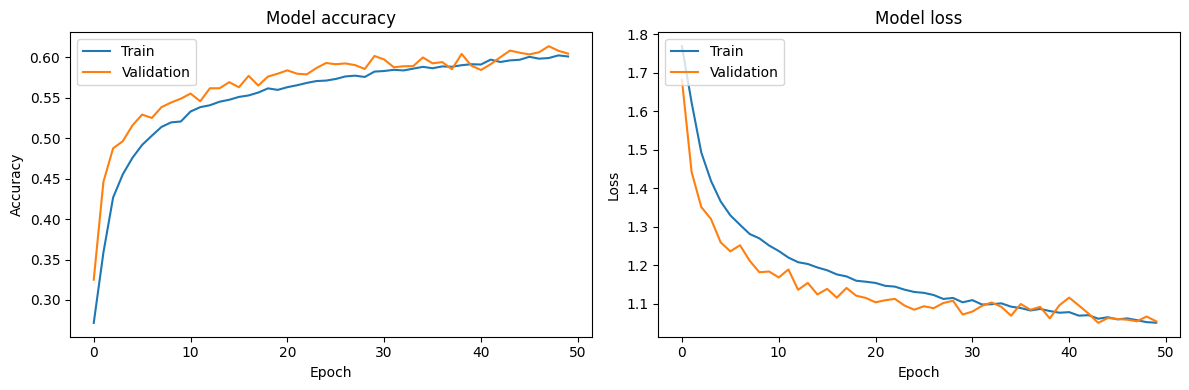

In [13]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [14]:
# Save the entire model
model.save('train3-e50-b64.h5')

C:\Users\User\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Epoch 100, Batch Size 64

In [15]:
# Define parameters
img_width, img_height = 48, 48
batch_size = 64
epochs = 100

In [16]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
# Load FER-2013 dataset
train_generator = train_datagen.flow_from_directory(
    r"C:\Users\User\OneDrive\Desktop\EmoSense\Face Emotion Recognition\fer2013\train",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    r"C:\Users\User\OneDrive\Desktop\EmoSense\Face Emotion Recognition\fer2013\test",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [18]:
# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 classes for the 7 emotions
])

In [19]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/100
448/448 [==============================] - 46s 101ms/step - loss: 1.7645 - accuracy: 0.2697 - val_loss: 1.6456 - val_accuracy: 0.3436
Epoch 2/100
448/448 [==============================] - 45s 101ms/step - loss: 1.6280 - accuracy: 0.3591 - val_loss: 1.4708 - val_accuracy: 0.4355
Epoch 3/100
448/448 [==============================] - 42s 93ms/step - loss: 1.4973 - accuracy: 0.4222 - val_loss: 1.3661 - val_accuracy: 0.4767
Epoch 4/100
448/448 [==============================] - 45s 101ms/step - loss: 1.4247 - accuracy: 0.4539 - val_loss: 1.3112 - val_accuracy: 0.4965
Epoch 5/100
448/448 [==============================] - 46s 102ms/step - loss: 1.3711 - accuracy: 0.4776 - val_loss: 1.2596 - val_accuracy: 0.5204
Epoch 6/100
448/448 [==============================] - 45s 101ms/step - loss: 1.3359 - accuracy: 0.4912 - val_loss: 1.2290 - val_accuracy: 0.5326
Epoch 7/100
448/448 [==============================] - 45s 101ms/step - loss: 1.3067 - accuracy: 0.5014 - val_loss: 1.2183 - 

Epoch 57/100
448/448 [==============================] - 43s 96ms/step - loss: 1.0289 - accuracy: 0.6119 - val_loss: 1.0657 - val_accuracy: 0.6141
Epoch 58/100
448/448 [==============================] - 49s 108ms/step - loss: 1.0305 - accuracy: 0.6102 - val_loss: 1.1039 - val_accuracy: 0.6064
Epoch 59/100
448/448 [==============================] - 56s 124ms/step - loss: 1.0250 - accuracy: 0.6134 - val_loss: 1.0534 - val_accuracy: 0.6235
Epoch 60/100
448/448 [==============================] - 63s 140ms/step - loss: 1.0258 - accuracy: 0.6111 - val_loss: 1.0735 - val_accuracy: 0.6073
Epoch 61/100
448/448 [==============================] - 48s 108ms/step - loss: 1.0200 - accuracy: 0.6163 - val_loss: 1.0614 - val_accuracy: 0.6170
Epoch 62/100
448/448 [==============================] - 56s 125ms/step - loss: 1.0284 - accuracy: 0.6105 - val_loss: 1.0518 - val_accuracy: 0.6147
Epoch 63/100
448/448 [==============================] - 49s 108ms/step - loss: 1.0157 - accuracy: 0.6153 - val_loss: 1.

In [21]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

113/113 [==============================] - 5s 47ms/step - loss: 1.0464 - accuracy: 0.6252
Validation Accuracy: 62.52%


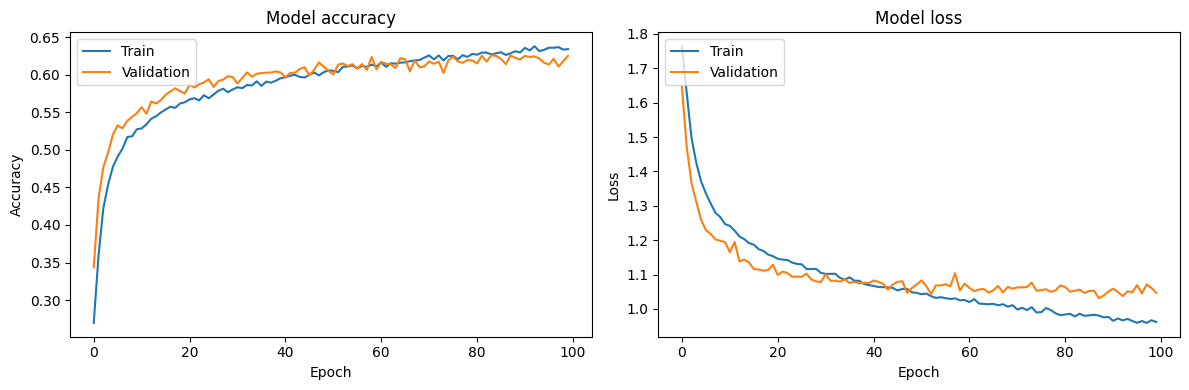

In [22]:
# Plotting training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [23]:
# Save the entire model
model.save('train3-e100-b64.h5')

In [ ]:
# Improved Model with Data Augmentation and Transfer Learning

In [ ]:
# Epoch 50 Batch Size 64

In [38]:
# Define parameters
img_width, img_height = 48, 48
batch_size = 128
epochs = 100

In [39]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [40]:
# Load the dataset
train_generator = train_datagen.flow_from_directory(
    r"C:\Users\User\OneDrive\Desktop\EmoSense\Face Emotion Recognition\fer2013\train",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    r"C:\Users\User\OneDrive\Desktop\EmoSense\Face Emotion Recognition\fer2013\test",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [41]:
# Build the model
input_layer = Input(shape=(img_width, img_height, 1))

# Convert grayscale to RGB
rgb_layer = Lambda(lambda x: tf.image.grayscale_to_rgb(x))(input_layer)

In [42]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Flatten, Dense, Dropout

# Load VGG16 with pre-trained weights and exclude top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of VGG16
x = base_model(rgb_layer)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(7, activation='softmax')(x)  # 7 classes for 7 emotions


In [43]:
# Define the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 lambda_4 (Lambda)           (None, 48, 48, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 7)                 3591

In [44]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/100
224/224 [==============================] - 278s 1s/step - loss: 1.7525 - accuracy: 0.2886 - val_loss: 1.6436 - val_accuracy: 0.3460
Epoch 2/100
224/224 [==============================] - 291s 1s/step - loss: 1.6949 - accuracy: 0.3209 - val_loss: 1.6179 - val_accuracy: 0.3588
Epoch 3/100
224/224 [==============================] - 289s 1s/step - loss: 1.6781 - accuracy: 0.3284 - val_loss: 1.6053 - val_accuracy: 0.3666
Epoch 4/100
224/224 [==============================] - 276s 1s/step - loss: 1.6715 - accuracy: 0.3306 - val_loss: 1.5886 - val_accuracy: 0.3758
Epoch 5/100
224/224 [==============================] - 278s 1s/step - loss: 1.6577 - accuracy: 0.3378 - val_loss: 1.5859 - val_accuracy: 0.3778
Epoch 6/100
224/224 [==============================] - 280s 1s/step - loss: 1.6594 - accuracy: 0.3404 - val_loss: 1.5841 - val_accuracy: 0.3754
Epoch 7/100
224/224 [==============================] - 286s 1s/step - loss: 1.6511 - accuracy: 0.3432 - val_loss: 1.5713 - val_accuracy:

224/224 [==============================] - 265s 1s/step - loss: 1.5876 - accuracy: 0.3730 - val_loss: 1.5125 - val_accuracy: 0.4103
Epoch 58/100
224/224 [==============================] - 266s 1s/step - loss: 1.5876 - accuracy: 0.3766 - val_loss: 1.5195 - val_accuracy: 0.4081
Epoch 59/100
224/224 [==============================] - 266s 1s/step - loss: 1.5891 - accuracy: 0.3745 - val_loss: 1.5148 - val_accuracy: 0.4153
Epoch 60/100
224/224 [==============================] - 265s 1s/step - loss: 1.5838 - accuracy: 0.3750 - val_loss: 1.5114 - val_accuracy: 0.4153
Epoch 61/100
224/224 [==============================] - 264s 1s/step - loss: 1.5856 - accuracy: 0.3755 - val_loss: 1.5046 - val_accuracy: 0.4162
Epoch 62/100
224/224 [==============================] - 275s 1s/step - loss: 1.5824 - accuracy: 0.3778 - val_loss: 1.5186 - val_accuracy: 0.4122
Epoch 63/100
224/224 [==============================] - 263s 1s/step - loss: 1.5850 - accuracy: 0.3773 - val_loss: 1.5184 - val_accuracy: 0.411

In [45]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')


57/57 [==============================] - 50s 883ms/step - loss: 1.5032 - accuracy: 0.4163
Validation Accuracy: 41.63%


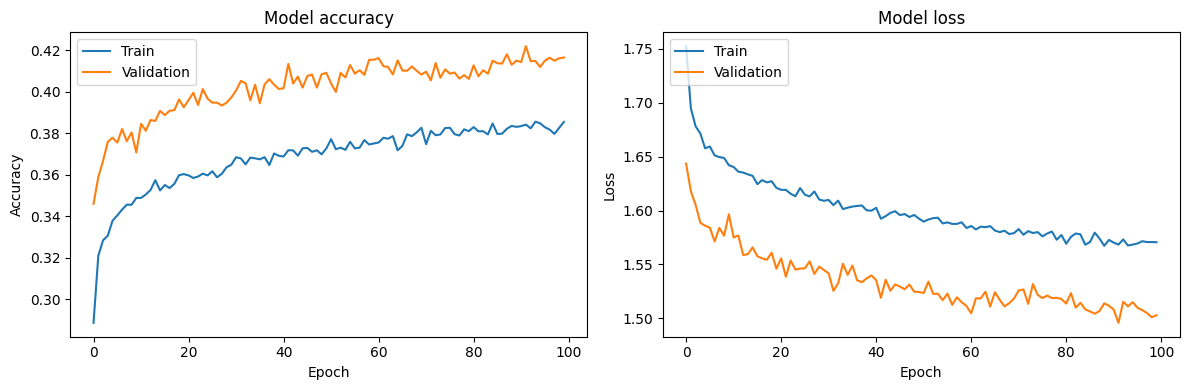

In [46]:
# Plotting training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [47]:
# Save the entire model
model.save('train4-VGG16.h5')

In [ ]:
# Define the model with adjusted architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu'),  # Added another Conv layer
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),  # Increased Dense layer size
    Dropout(0.5),
    Dense(7, activation='softmax')
])

# Compile with a different learning rate
optimizer = Adam(learning_rate=0.0001)  # Decreased learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
# 2nd train

In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    brightness_range=[0.8, 1.2]
)
datagen.fit(X_train)

In [ ]:
# Transfer Learning with VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
# Build model on top of VGG16
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

In [ ]:
# Freeze the base model layers
base_model.trainable = False

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


In [ ]:
# Train the model
batch_size = 64
epochs = 30

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    callbacks=[reduce_lr, checkpoint]
)

# Load the best model
from tensorflow.keras.models import load_model
model = load_model('best_model.h5')

# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')